# Medi Bot

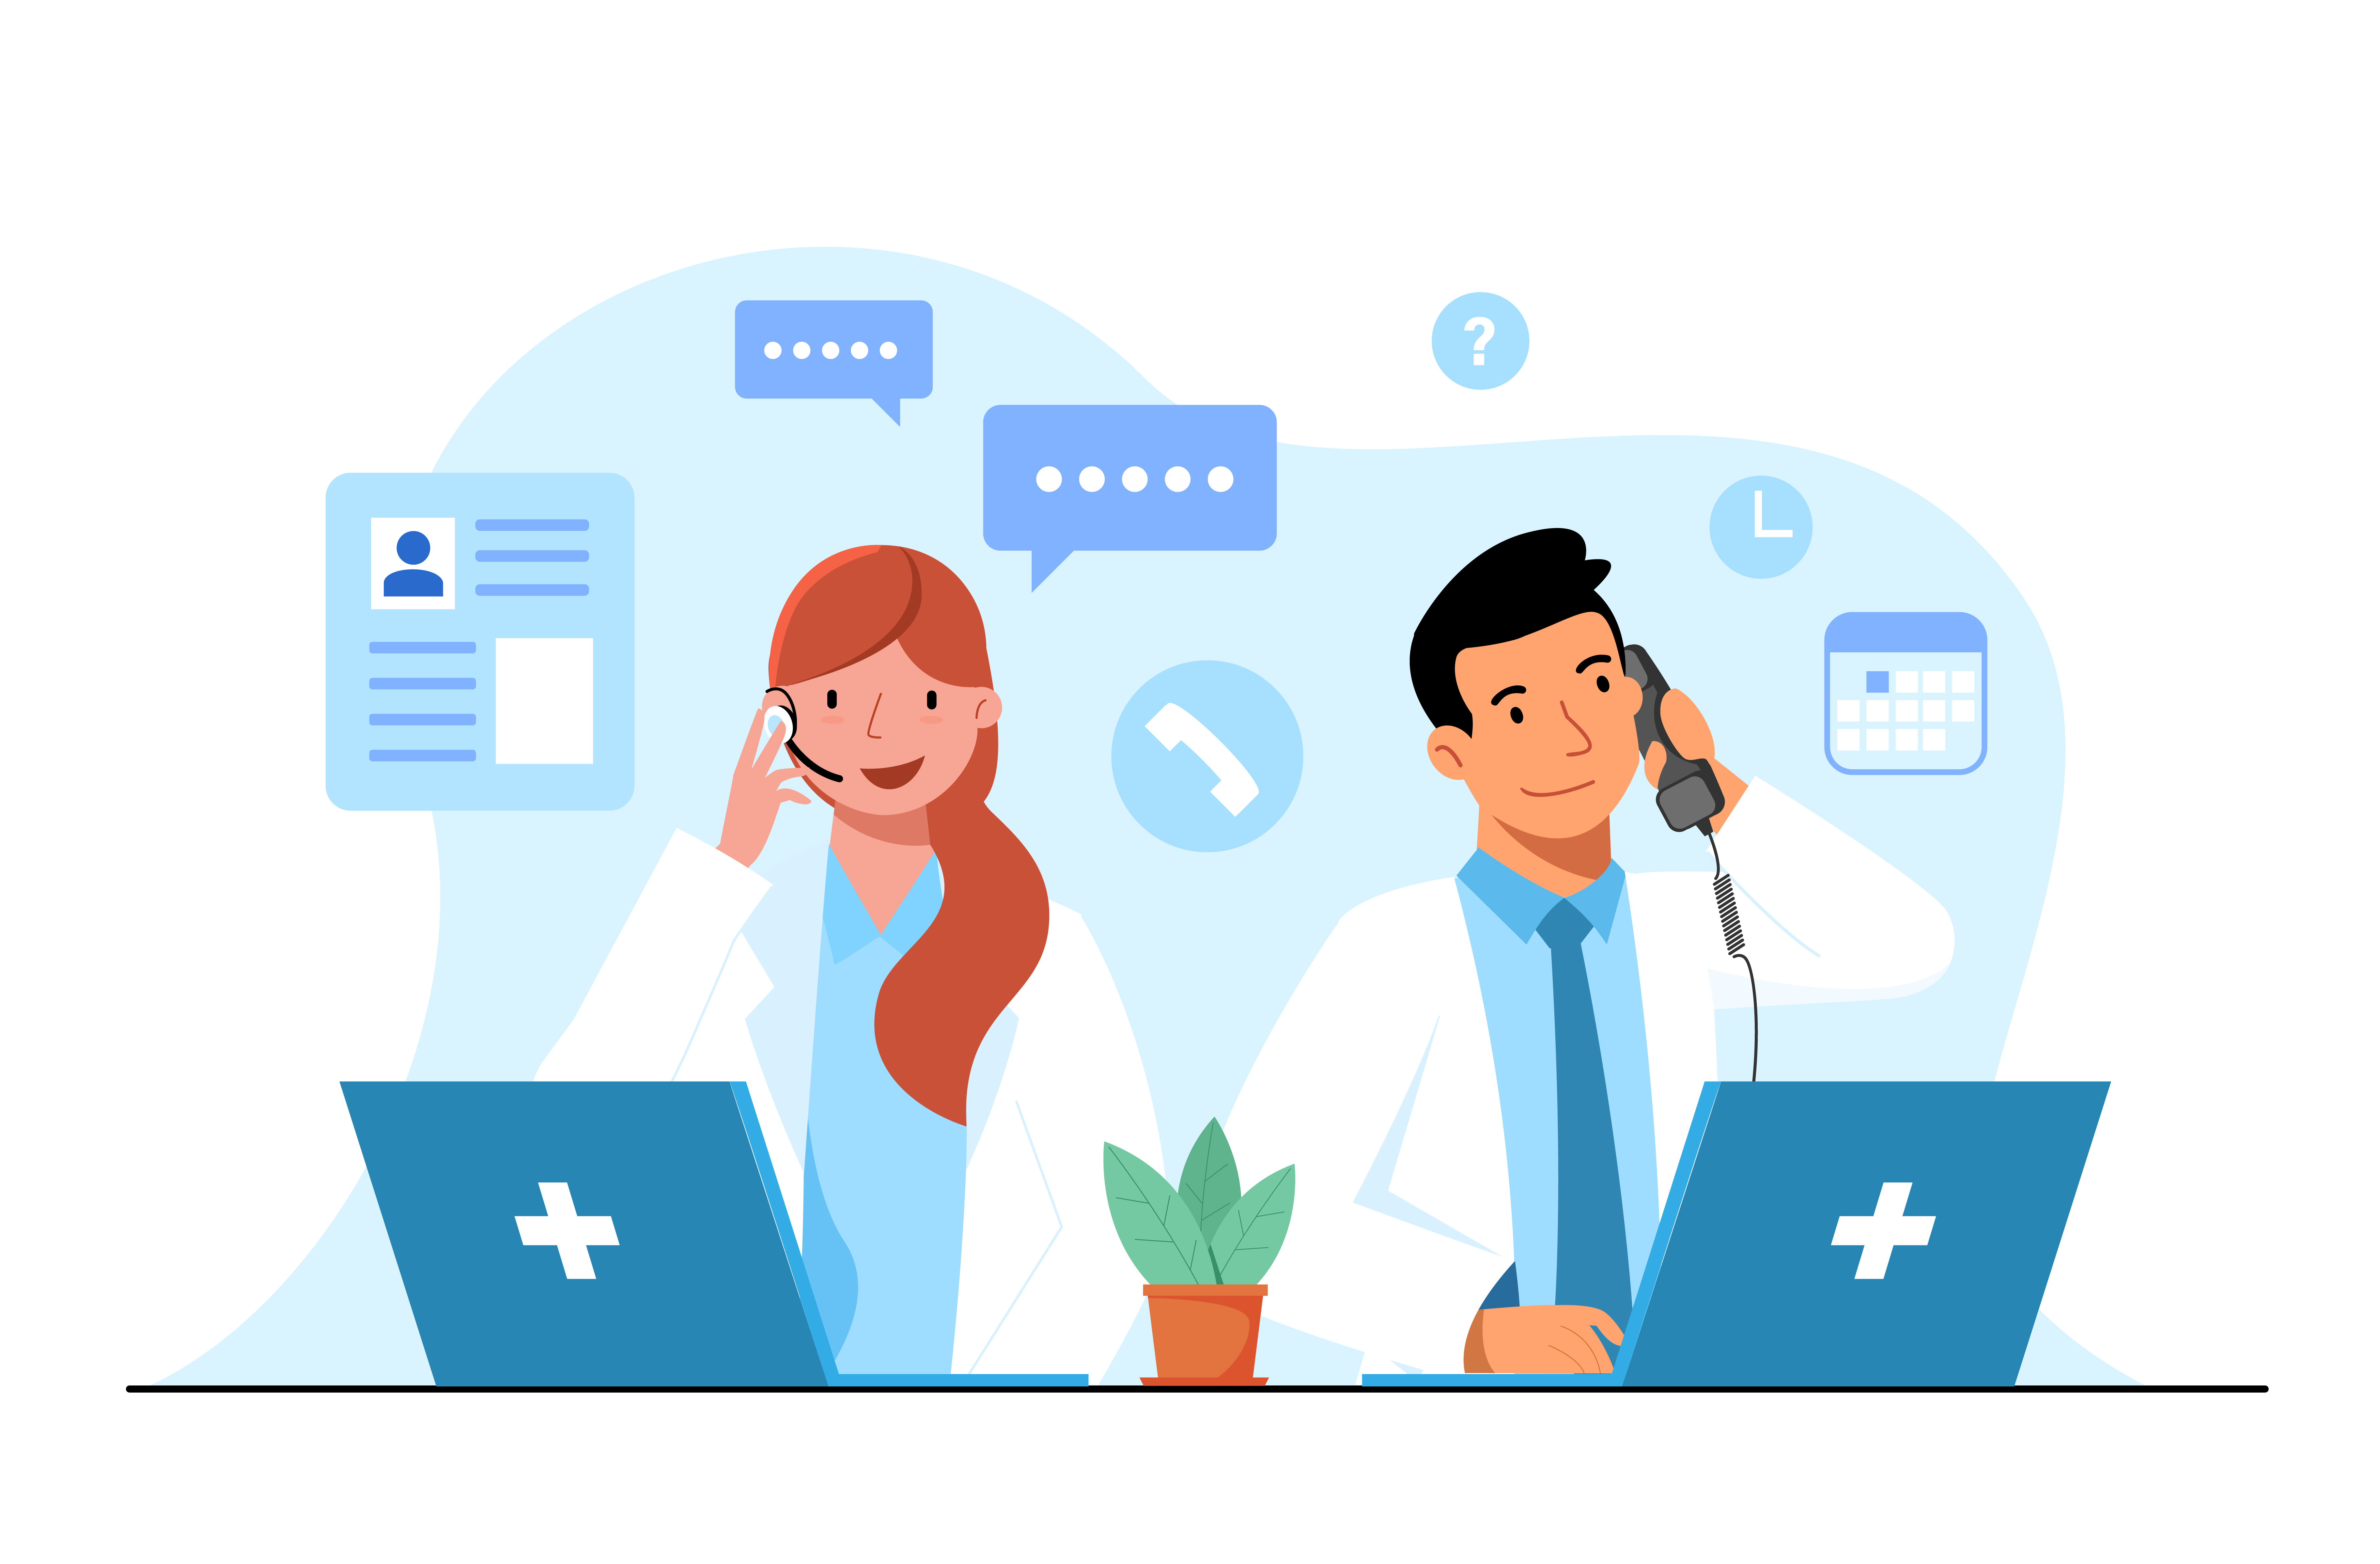

### **Installation of required libraries**

In [ ]:
!pip install streamlit
!pip install pyngrok==4.1.1
!pip install nltk
!pip install torch
!pip install reportlab
!pip install -q pyspellchecker==0.6.3

### **Importing required libraries**

In [1]:
import numpy as np
import random
import json
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('punkt')
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import random
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
import random
import re
import pandas as pd
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from reportlab.lib.utils import ImageReader
import io
from spellchecker import SpellChecker

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Vimalkumar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### **Hopf Oscillator Function**

A Hopf bifurcation is a critical point where a system’s stability switches and a periodic solution arises as a parameter changes. More accurately, it is a local bifurcation in which a fixed point of a dynamical system loses stability, as a pair of complex conjugate eigenvalues of the linearization around the fixed point crosses the complex plane imaginary axis.

In [2]:
def hopf_oscillator(dt, num_steps, alpha, beta, gamma, omega):
    x, y = 0.1, 0.0
    states = []
    for _ in range(num_steps):
        dx = alpha * x - omega * y + beta * x * (x ** 2 + y ** 2)
        dy = omega * x + alpha * y + beta * y * (x ** 2 + y ** 2)
        x += dx * dt
        y += dy * dt
        emotion_intensity = np.sqrt(x ** 2 + y ** 2)
        states.append((x, y, emotion_intensity))
    return states

# **Natural Language Processing Tools Function**

In [3]:
stemmer = PorterStemmer()

def tokenize(sentence):
    return nltk.word_tokenize(sentence)

def stem(word):
    return stemmer.stem(word.lower())

def bag_of_words(tokenized_sentence, all_words):
    sentence_words = [stem(word) for word in tokenized_sentence]
    bag = np.zeros(len(all_words), dtype=np.float32)
    for idx, w in enumerate(all_words):
        if w in sentence_words:
            bag[idx] = 1
    return bag

# **Neural Network Class**

In [4]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        return out


In [5]:
with open('dialogue_config.json', 'r') as file:
    dialogue_config = json.load(file)

#print(dialogue_config)
all_words = []
tags = []
xy = []

for dialogue in dialogue_config['intents']:
    tag = dialogue['tag']
    tags.append(tag)
    for pattern in dialogue['patterns']:
        w = tokenize(pattern)
        all_words.extend(w)
        xy.append((w, tag))

ignore_words = ['?', '.', '!']
all_words = [stem(w) for w in all_words if w not in ignore_words]
all_words = sorted(set(all_words))
tags = sorted(set(tags))

X_train = np.array([bag_of_words(pattern_sentence, all_words) for pattern_sentence, _ in xy])
y_train = np.array([tags.index(tag) for _, tag in xy])
print(X_train[0],tags)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.] ['appointment', 'covid', 'diet', 'emergency', 'exercise', 'goodbye', 'greeting', 'healthtips', 'hours', 'hydration', 'insurance', 'medication', 'mentalhealth', 'skincare', 'sleep', 'symptoms', 'testresults', 'thanks', 'vaccination']


In [6]:
print(len(X_train[0]),len(tags))

122 19


# **Preparation of Chat Dataset Class and Training**

In [7]:
class ChatDataset(Dataset):
    def __init__(self):
        self.n_samples = len(X_train)
        self.x_data = X_train
        self.y_data = y_train

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.n_samples

emotional_state = 0.0
conversation_history = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeuralNet(len(X_train[0]), 8, len(tags)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_loader = DataLoader(dataset=ChatDataset(), batch_size=8, shuffle=True)

num_epochs = 1000
for epoch in range(num_epochs):
    for (words, labels) in train_loader:
        words = words.to(device)
        labels = labels.to(dtype=torch.long).to(device)

        outputs = model(words)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print('Training complete.')

torch.save(model.state_dict(), 'chat_model.pth')
print('Model saved.')

Epoch [1000/1000], Loss: 0.0001
Training complete.
Model saved.


In [8]:
torch.save(model, 'chat_model_2.pth')
print('Model saved.')

Model saved.


# **Analyze Sentiment Function**

In [9]:
def analyze_sentiment(sentence):
    positive_words = ['happy', 'great', 'fantastic', 'good', 'love']
    negative_words = ['sad', 'bad', 'terrible', 'hate', 'horrible']
    sentiment_score = 0
    for word in sentence.split():
        if word.lower() in positive_words:
            sentiment_score += 1
        elif word.lower() in negative_words:
            sentiment_score -= 1
    return 'positive' if sentiment_score > 0 else 'negative' if sentiment_score < 0 else 'neutral'


# **Adjusting emotional state function**

In [10]:
def adjust_emotional_state(sentiment, emotional_state):
    if sentiment == 'positive':
        emotional_state += 0.1
    elif sentiment == 'negative':
        emotional_state -= 0.1
    return max(min(emotional_state, 1), -1)


# **Generation of Response function**

In [11]:
def generate_context_aware_response(emotional_state):
    if emotional_state > 0.5:
        return "You seem in a good mood! Anything else you'd like to discuss?"
    elif emotional_state < -0.5:
        return "I'm sensing some negativity. Would you like to talk about what's bothering you?"
    else:
        return "I see. Can you elaborate on that a bit more?"


# **Saving this conversation as a text file**

In [12]:
def save_conversation_logs(sentence, bot_response):
    with open("conversation_logs.txt", "a") as file:
        file.write(f"User: {sentence}\nBot: {bot_response}\n")


# **Plotting of Emotional Distribution based on intensity**

In [13]:
def plot_emotion_distribution(emotion_states):
    intensities = [state[2] for state in emotion_states]
    positive = sum(1 for i in intensities if i > 0.5)
    negative = sum(1 for i in intensities if i < -0.5)
    neutral = len(intensities) - positive - negative
    labels = 'Positive', 'Neutral', 'Negative'
    sizes = [positive, neutral, negative]
    colors = ['lightgreen', 'gray', 'lightcoral']
    explode = (0.1, 0, 0)
    plt.figure(figsize=(7, 7))
    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')
    plt.show()


# **Emotion Heatmap**

In [14]:
def plot_emotion_heatmap(emotion_states):
    timestamps = range(len(emotion_states))
    intensities = [state[2] for state in emotion_states]
    data = np.array([intensities])
    plt.figure(figsize=(15, 5))
    sns.heatmap(data, yticklabels=['Emotion'], xticklabels=timestamps, cmap='coolwarm', cbar_kws={'label': 'Emotional Intensity'})
    plt.title('Emotional Intensity Over Time')
    plt.xlabel('Time')
    plt.ylabel('Emotional State')
    plt.show()

In [13]:
spelling = SpellChecker(distance=1)
def misspelt_words_fn(input):
    misspelt_words = set()
    [misspelt_words.add(word) for word in spelling.unknown(input.split())]
    return list(misspelt_words)

WORD = re.compile(r'\w+')
def reTokenize(sentence):
    return WORD.findall(sentence.casefold())

PATTERN = re.compile(r"(.)\1{2,}", flags=re.IGNORECASE)
def reduce_lengthening(text):
    return PATTERN.sub(r"\1\1", text)
    
def spell_correction(text, misspelt_list):
    return ' '.join([spelling.correction(word)
                     if word in misspelt_list else word
                     for word in reTokenize(reduce_lengthening(text))])


# **Application of Model**

In [16]:
bot_name = "Meditbot"
print("Let's chat! (type 'quit' to exit)")

emotional_state = 0.0
conversation_history = []

def handle_specific_queries(tag, user_input):
    if tag == 'appointment':
        return "To schedule an appointment, please visit our website or call our office."
    elif tag == 'symptoms':
        return "If you're experiencing symptoms, please provide more details or consider visiting a doctor."
    return "Can you provide more details?"

while True:
    user_input = input("You: ")
    if user_input.lower() == "quit":
        break

    misspelt_words = misspelt_words_fn(user_input)
    user_input = spell_correction(user_input, misspelt_words)
    
    sentence_tokens = tokenize(user_input)
    X_input = bag_of_words(sentence_tokens, all_words)
    X_input = torch.from_numpy(X_input).to(device).float().unsqueeze(0)

    sentiment = analyze_sentiment(user_input)
    emotional_state = adjust_emotional_state(sentiment, emotional_state)

    model.eval()
    with torch.no_grad():
        output = model(X_input)
        _, predicted = torch.max(output, dim=1)
        tag = tags[predicted.item()]

    response = None
    if tag in ['appointment', 'symptoms']:
        response = handle_specific_queries(tag, user_input)
    else:
        for dialogue in dialogue_config['intents']:
            if tag == dialogue['tag']:
                response = random.choice(dialogue['responses'])
                break
    if response:
        context_response = generate_context_aware_response(emotional_state)
        print(f"{bot_name}: {response} {context_response}")
    else:
        print(f"{bot_name}: I'm not sure how to respond to that.")
    save_conversation_logs(user_input, f"{response} {context_response if response else ''}")
    conversation_history.append((user_input, sentiment, emotional_state, response))


Let's chat! (type 'quit' to exit)


You:  What are all the symtms of covid?


Meditbot: Protect your skin from the sun by wearing sunscreen, moisturize daily, and stay hydrated. Avoid smoking and harsh skin products. I see. Can you elaborate on that a bit more?


You:  quit


# **Data Analysis of the chat in the form of a Report**

**Analysis-1**

In [19]:
def analyze_line(line):
    features = {}
    words = line.split()

    features['length_of_message'] = len(line)
    features['word_count'] = len(words)
    features['question'] = "?" in line
    features['exclamation'] = "!" in line
    features['politeness'] = any(word in line.lower() for word in ["please", "thank you"])
    blob = TextBlob(line)
    features['sentiment'] = blob.sentiment.polarity
    features['urgency'] = any(word in line.lower() for word in ["now", "immediately"])
    features['personal_pronouns'] = sum(1 for word in words if word.lower() in ["i", "me", "my"])
    features['average_word_length'] = sum(len(word) for word in words) / len(words) if words else 0

    return features

def analyze_conversation_log(filename):
    analysis_results = []
    with open(filename, 'r') as file:
        for line in file:
            analysis_results.append(analyze_line(line))
    return analysis_results

filename = 'conversation_logs.txt'
results = analyze_conversation_log(filename)
print(results)


[{'length_of_message': 42, 'word_count': 8, 'question': True, 'exclamation': False, 'politeness': False, 'sentiment': 0.0, 'urgency': False, 'personal_pronouns': 1, 'average_word_length': 4.25}, {'length_of_message': 254, 'word_count': 40, 'question': True, 'exclamation': False, 'politeness': False, 'sentiment': 0.2619047619047619, 'urgency': False, 'personal_pronouns': 1, 'average_word_length': 5.35}, {'length_of_message': 47, 'word_count': 10, 'question': True, 'exclamation': False, 'politeness': False, 'sentiment': 0.0, 'urgency': False, 'personal_pronouns': 2, 'average_word_length': 3.7}, {'length_of_message': 119, 'word_count': 23, 'question': True, 'exclamation': False, 'politeness': False, 'sentiment': 0.5, 'urgency': False, 'personal_pronouns': 2, 'average_word_length': 4.173913043478261}, {'length_of_message': 38, 'word_count': 7, 'question': True, 'exclamation': False, 'politeness': False, 'sentiment': 0.0, 'urgency': False, 'personal_pronouns': 2, 'average_word_length': 4.42

**Analysis-2**

C:\Users\Vimalkumar\AppData\Local\Temp\ipykernel_17836\370005302.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=message_counts.index, y=message_counts.values, palette='pastel')


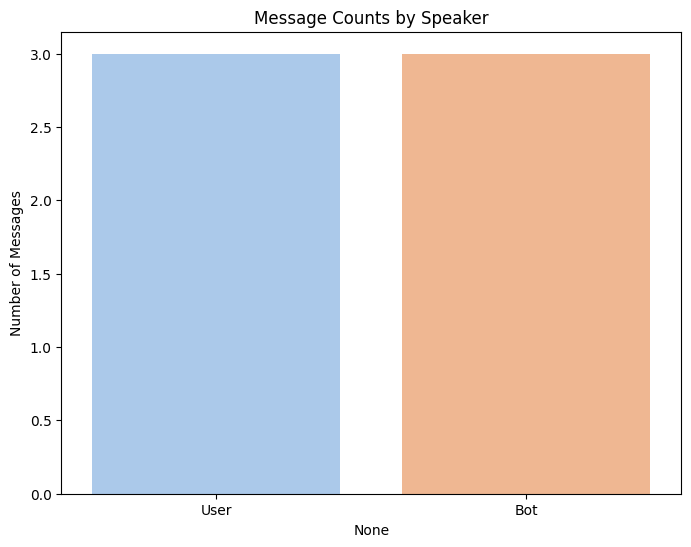

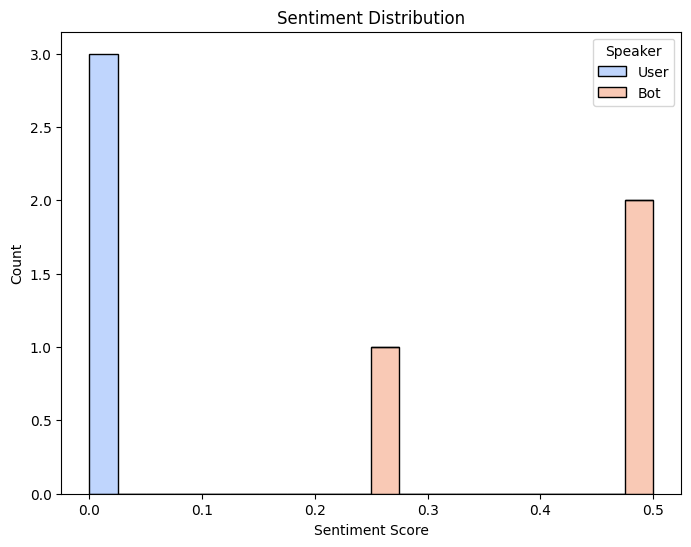

Total number of messages: 6
Number of messages by User: 3
Number of messages by Bot: 3
Average sentiment by User: 0.00
Average sentiment by Bot: 0.42


C:\Users\Vimalkumar\AppData\Local\Temp\ipykernel_17836\370005302.py:36: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='Speaker', y='Sentiment', ci=None, palette='pastel')
C:\Users\Vimalkumar\AppData\Local\Temp\ipykernel_17836\370005302.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Speaker', y='Sentiment', ci=None, palette='pastel')


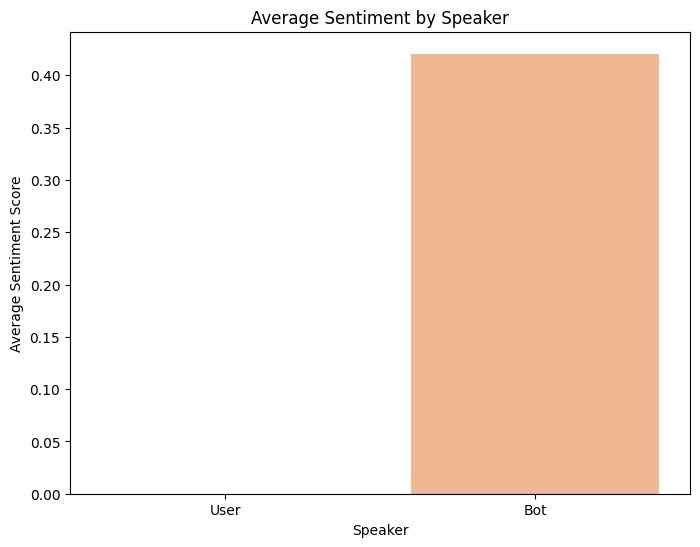

In [20]:
speakers = []
messages = []

with open('conversation_logs.txt', 'r') as file:
    for line in file:
        line = line.strip()
        if line.startswith('User: '):
            speakers.append('User')
            messages.append(line[6:])
        elif line.startswith('Bot: '):
            speakers.append('Bot')
            messages.append(line[5:])

df = pd.DataFrame({
    'Speaker': speakers,
    'Message': messages
})

df['Sentiment'] = df['Message'].apply(lambda x: TextBlob(x).sentiment.polarity)

message_counts = df['Speaker'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=message_counts.index, y=message_counts.values, palette='pastel')
plt.title('Message Counts by Speaker')
plt.ylabel('Number of Messages')
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Sentiment', hue='Speaker', multiple='stack', bins=20, palette='coolwarm')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8, 6))
sns.barplot(data=df, x='Speaker', y='Sentiment', ci=None, palette='pastel')
plt.title('Average Sentiment by Speaker')
plt.ylabel('Average Sentiment Score')

print(f"Total number of messages: {len(df)}")
print(f"Number of messages by User: {message_counts.get('User', 0)}")
print(f"Number of messages by Bot: {message_counts.get('Bot', 0)}")
print(f"Average sentiment by User: {df[df['Speaker'] == 'User']['Sentiment'].mean():.2f}")
print(f"Average sentiment by Bot: {df[df['Speaker'] == 'Bot']['Sentiment'].mean():.2f}")


**Analysis-3**

In [21]:
message_counts_plot = io.BytesIO()
plt.figure(figsize=(8, 6))
sns.barplot(x=message_counts.index, y=message_counts.values, palette='pastel')
plt.title('Message Counts by Speaker')
plt.ylabel('Number of Messages')
plt.savefig(message_counts_plot, format='PNG')
message_counts_plot.seek(0)

sentiment_distribution_plot = io.BytesIO()
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Sentiment', hue='Speaker', multiple='stack', bins=20, palette='coolwarm')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.savefig(sentiment_distribution_plot, format='PNG')
sentiment_distribution_plot.seek(0)

average_sentiment_plot = io.BytesIO()
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x='Speaker', y='Sentiment', ci=None, palette='pastel')
plt.title('Average Sentiment by Speaker')
plt.ylabel('Average Sentiment Score')
plt.savefig(average_sentiment_plot, format='PNG')
average_sentiment_plot.seek(0)

c = canvas.Canvas("conversation_analysis_report.pdf", pagesize=letter)
width, height = letter

c.setFont("Helvetica-Bold", 24)
c.drawCentredString(width / 2, height - 50, "Conversation Analysis Report")
c.drawImage(ImageReader(message_counts_plot), 100, height - 300, width=400, height=200)
c.drawImage(ImageReader(sentiment_distribution_plot), 100, height - 550, width=400, height=200)
c.drawImage(ImageReader(average_sentiment_plot), 100, height - 800, width=400, height=200)

c.setFont("Helvetica", 12)
text_stats = [
    f"Total number of messages: {len(df)}",
    f"Number of messages by User: {message_counts.get('User', 0)}",
    f"Number of messages by Bot: {message_counts.get('Bot', 0)}",
    f"Average sentiment by User: {df[df['Speaker'] == 'User']['Sentiment'].mean():.2f}",
    f"Average sentiment by Bot: {df[df['Speaker'] == 'Bot']['Sentiment'].mean():.2f}"
]
text_y_position = height - 850
for stat in text_stats:
    c.drawString(100, text_y_position, stat)
    text_y_position -= 20

c.save()
plt.close('all')


C:\Users\Vimalkumar\AppData\Local\Temp\ipykernel_17836\4254160772.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=message_counts.index, y=message_counts.values, palette='pastel')
C:\Users\Vimalkumar\AppData\Local\Temp\ipykernel_17836\4254160772.py:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='Speaker', y='Sentiment', ci=None, palette='pastel')
C:\Users\Vimalkumar\AppData\Local\Temp\ipykernel_17836\4254160772.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Speaker', y='Sentiment', ci=None, palette='pastel')


**Analysis-4**

C:\Users\Vimalkumar\AppData\Local\Temp\ipykernel_17836\2420053147.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=question_counts.index, y=question_counts.values, palette='autumn')


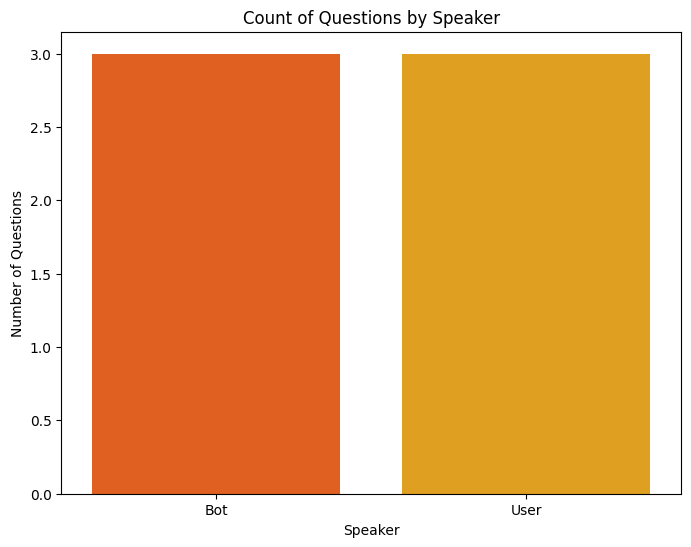

C:\Users\Vimalkumar\AppData\Local\Temp\ipykernel_17836\2420053147.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=urgency_counts.index, y=urgency_counts.values, palette='winter')


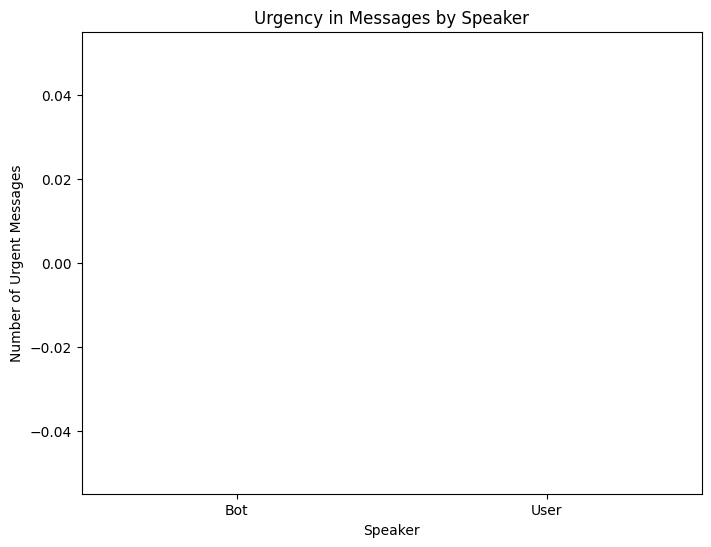

C:\Users\Vimalkumar\AppData\Local\Temp\ipykernel_17836\2420053147.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_word_count.index, y=avg_word_count.values, palette='spring')


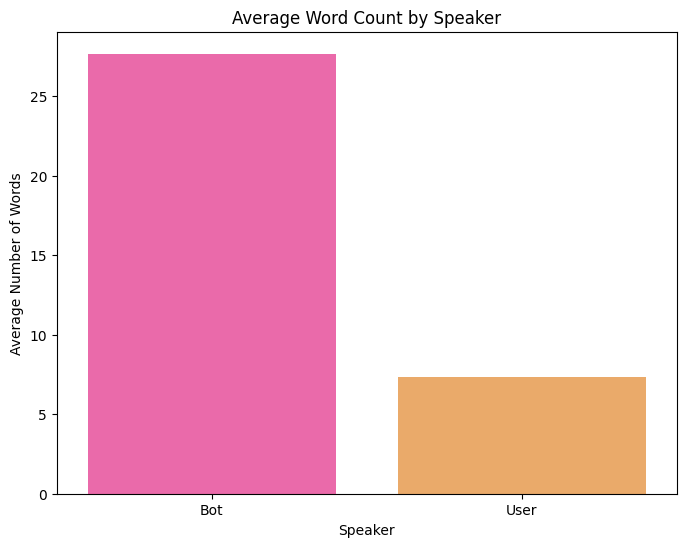

C:\Users\Vimalkumar\AppData\Local\Temp\ipykernel_17836\2420053147.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=exclamation_counts.index, y=exclamation_counts.values, palette='summer')


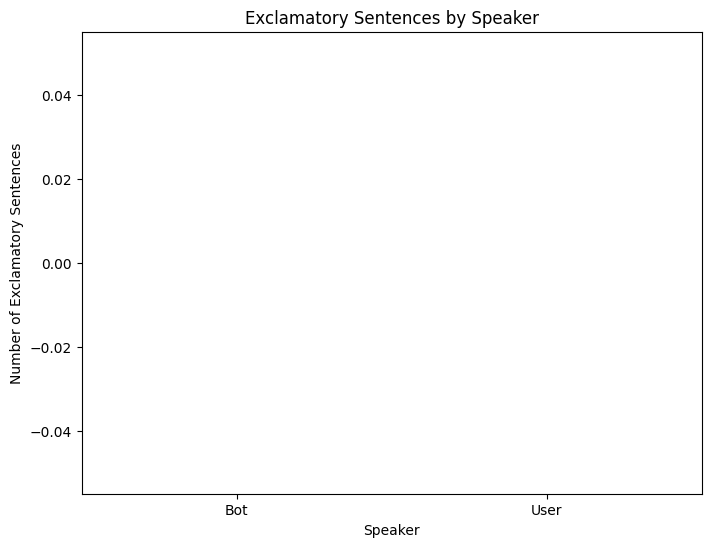

C:\Users\Vimalkumar\AppData\Local\Temp\ipykernel_17836\2420053147.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=thank_counts.index, y=thank_counts.values, palette='cool')


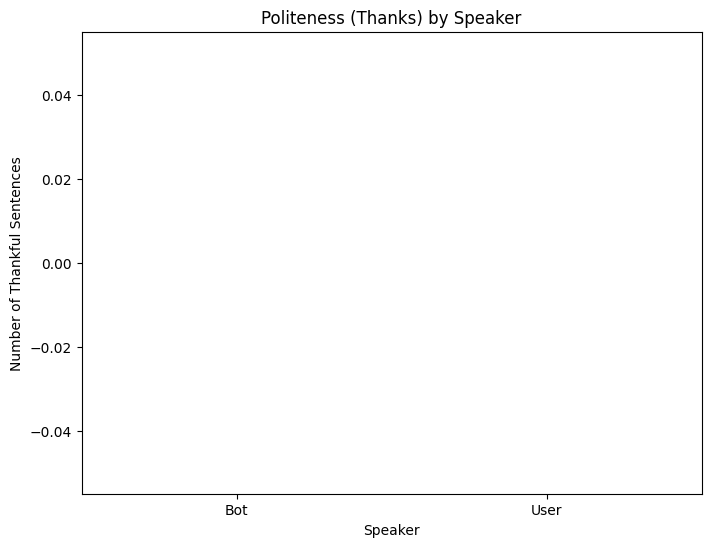

Total number of urgent messages: 0
Total number of questions asked: 6
Total number of exclamatory sentences: 0
Total instances of politeness (thanks): 0


In [22]:
df['Is Question'] = df['Message'].apply(lambda x: '?' in x)
df['Is Urgent'] = df['Message'].apply(lambda x: 'urgent' in x.lower() or 'asap' in x.lower() or 'immediately' in x.lower())
df['Word Count'] = df['Message'].apply(lambda x: len(x.split()))
df['Has Exclamation'] = df['Message'].apply(lambda x: '!' in x)
df['Contains Thank'] = df['Message'].apply(lambda x: 'thank' in x.lower())

question_counts = df.groupby('Speaker')['Is Question'].sum()
plt.figure(figsize=(8, 6))
sns.barplot(x=question_counts.index, y=question_counts.values, palette='autumn')
plt.title('Count of Questions by Speaker')
plt.ylabel('Number of Questions')
plt.show()

urgency_counts = df.groupby('Speaker')['Is Urgent'].sum()
plt.figure(figsize=(8, 6))
sns.barplot(x=urgency_counts.index, y=urgency_counts.values, palette='winter')
plt.title('Urgency in Messages by Speaker')
plt.ylabel('Number of Urgent Messages')
plt.show()

avg_word_count = df.groupby('Speaker')['Word Count'].mean()
plt.figure(figsize=(8, 6))
sns.barplot(x=avg_word_count.index, y=avg_word_count.values, palette='spring')
plt.title('Average Word Count by Speaker')
plt.ylabel('Average Number of Words')
plt.show()

exclamation_counts = df.groupby('Speaker')['Has Exclamation'].sum()
plt.figure(figsize=(8, 6))
sns.barplot(x=exclamation_counts.index, y=exclamation_counts.values, palette='summer')
plt.title('Exclamatory Sentences by Speaker')
plt.ylabel('Number of Exclamatory Sentences')
plt.show()

thank_counts = df.groupby('Speaker')['Contains Thank'].sum()
plt.figure(figsize=(8, 6))
sns.barplot(x=thank_counts.index, y=thank_counts.values, palette='cool')
plt.title('Politeness (Thanks) by Speaker')
plt.ylabel('Number of Thankful Sentences')
plt.show()

print(f"Total number of urgent messages: {df['Is Urgent'].sum()}")
print(f"Total number of questions asked: {df['Is Question'].sum()}")
print(f"Total number of exclamatory sentences: {df['Has Exclamation'].sum()}")
print(f"Total instances of politeness (thanks): {df['Contains Thank'].sum()}")


**Analysis-5**

Total number of sentiment polarity shifts: 0


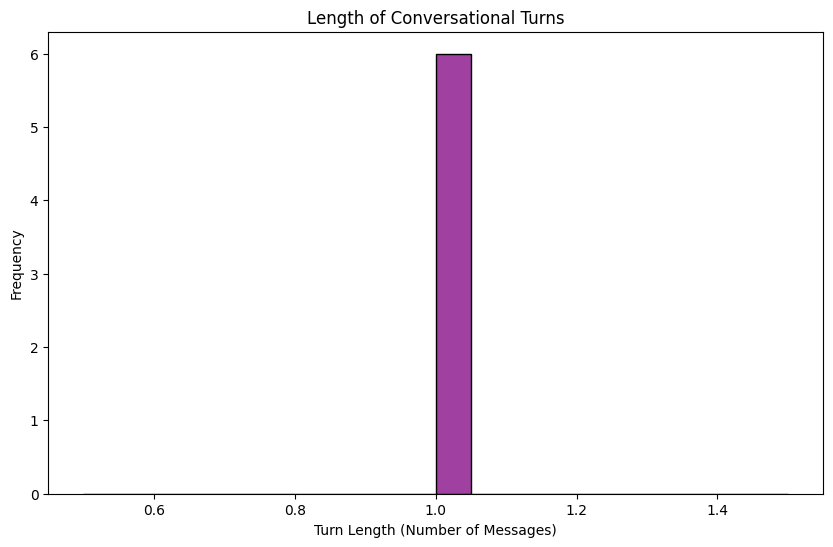

Total instances of laughter or humor: 0
Unique word counts by speaker: {'Bot': 43, 'User': 19}


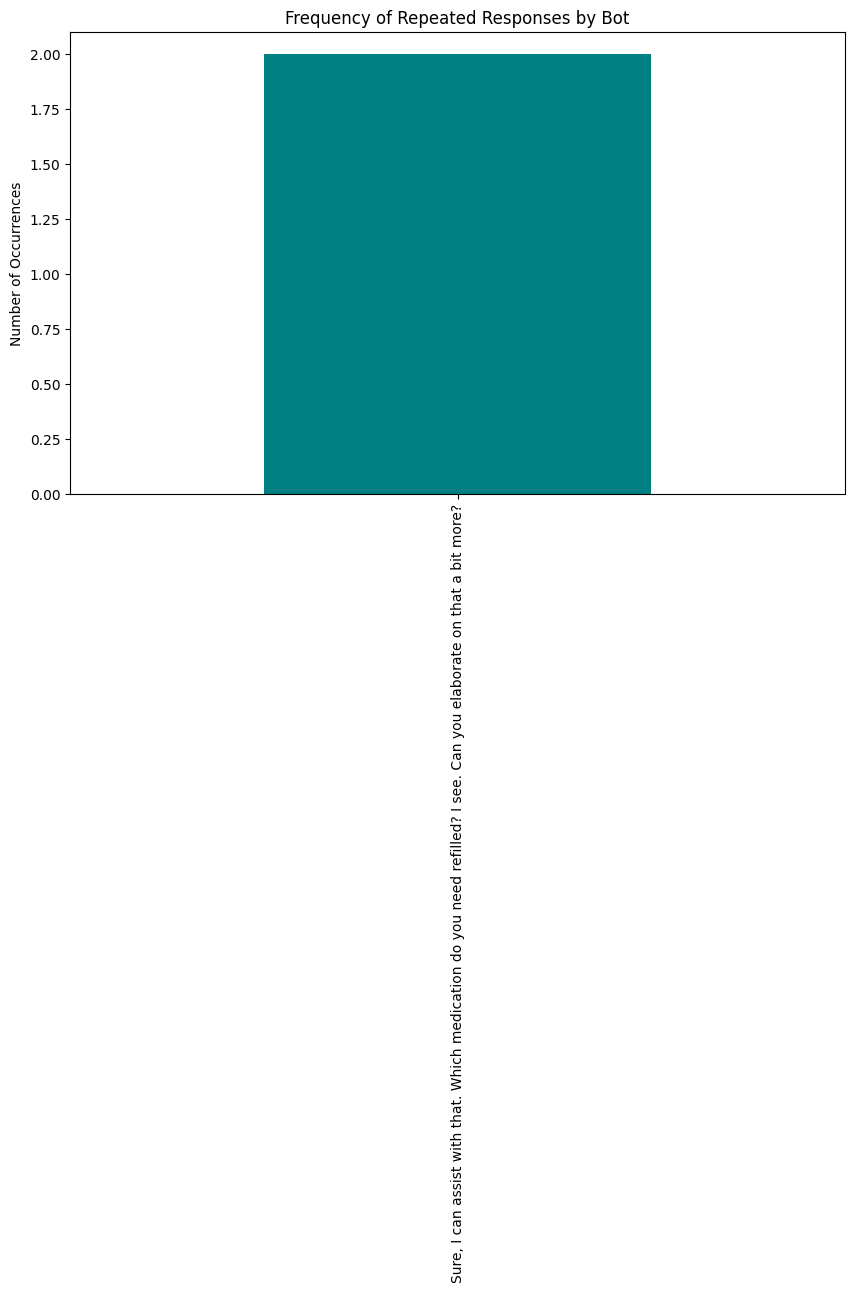

C:\Users\Vimalkumar\AppData\Local\Temp\ipykernel_17836\3831100853.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=starter_counts.index, y=starter_counts.values, palette='viridis')


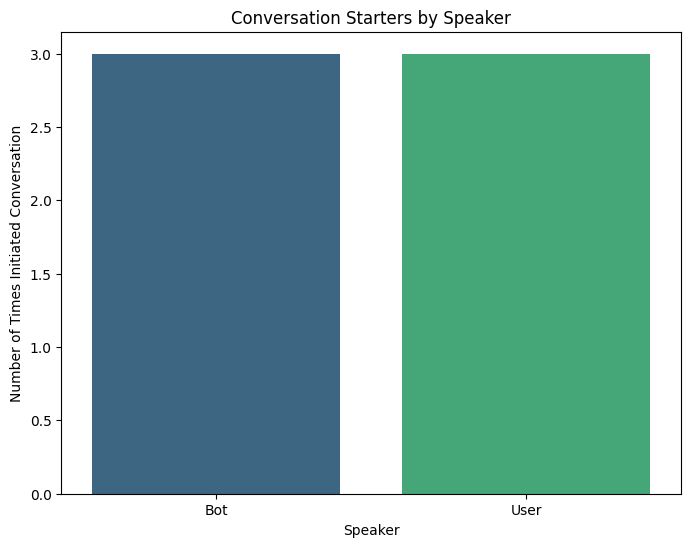

Measure of conversation interactivity: 1.00


In [23]:
df['Sentiment'] = df['Message'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['Sentiment Category'] = pd.cut(df['Sentiment'], bins=[-1, -0.01, 0.01, 1], labels=['Negative', 'Neutral', 'Positive'])
df['Sentiment'] = df['Message'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['Sentiment Category'] = pd.cut(df['Sentiment'], bins=[-1, -0.01, 0.01, 1], labels=['Negative', 'Neutral', 'Positive'])
df['Prev Sentiment Category'] = df['Sentiment Category'].shift(1)
df['Sentiment Shift'] = ((df['Sentiment Category'] == 'Positive') & (df['Prev Sentiment Category'] == 'Negative')) | \
                        ((df['Sentiment Category'] == 'Negative') & (df['Prev Sentiment Category'] == 'Positive'))
shift_counts = df['Sentiment Shift'].sum()
print(f"Total number of sentiment polarity shifts: {shift_counts}")

df['Prev Speaker'] = df['Speaker'].shift(1)
df['New Turn'] = df['Speaker'] != df['Prev Speaker']
turn_lengths = df.groupby((df['New Turn'].cumsum())).size()
plt.figure(figsize=(10, 6))
sns.histplot(turn_lengths, bins=20, color='purple')
plt.title('Length of Conversational Turns')
plt.xlabel('Turn Length (Number of Messages)')
plt.ylabel('Frequency')
plt.show()

df['Contains Laughter'] = df['Message'].apply(lambda x: 'lol' in x.lower() or 'haha' in x.lower())
laughter_counts = df['Contains Laughter'].sum()
print(f"Total instances of laughter or humor: {laughter_counts}")

df['Unique Words'] = df.apply(lambda x: set(x['Message'].lower().split()), axis=1)
unique_words_by_speaker = df.groupby('Speaker')['Unique Words'].agg(lambda words: set.union(*words))

unique_word_counts = {speaker: len(words) for speaker, words in unique_words_by_speaker.items()}
print(f"Unique word counts by speaker: {unique_word_counts}")

bot_repeated_responses = df[df['Speaker'] == 'Bot']['Message'].value_counts()
plt.figure(figsize=(10, 6))
bot_repeated_responses[bot_repeated_responses > 1].plot(kind='bar', color='teal')
plt.title('Frequency of Repeated Responses by Bot')
plt.ylabel('Number of Occurrences')
plt.show()

df['Conversation Starter'] = df['New Turn'] & (df['Prev Speaker'] != df['Speaker'])
starter_counts = df.groupby('Speaker')['Conversation Starter'].sum()
plt.figure(figsize=(8, 6))
sns.barplot(x=starter_counts.index, y=starter_counts.values, palette='viridis')
plt.title('Conversation Starters by Speaker')
plt.ylabel('Number of Times Initiated Conversation')
plt.show()

conversation_interactivity = df['New Turn'].sum() / len(df) if len(df) > 0 else 0
print(f"Measure of conversation interactivity: {conversation_interactivity:.2f}")


**Analysis-6**

In [24]:
def save_plot_to_image(plt_function):
    image_buffer = io.BytesIO()
    plt_function()
    plt.savefig(image_buffer, format='PNG', bbox_inches='tight')
    plt.close()
    image_buffer.seek(0)
    return image_buffer

def plot_message_counts():
    message_counts = df['Speaker'].value_counts()
    sns.barplot(x=message_counts.index, y=message_counts.values, palette='pastel')
    plt.title('Message Counts by Speaker')
    plt.ylabel('Number of Messages')

def plot_sentiment_distribution():
    sns.histplot(data=df, x='Sentiment', hue='Speaker', multiple='stack', bins=20, palette='coolwarm')
    plt.title('Sentiment Distribution')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Count')

def plot_question_counts():
    question_counts = df.groupby('Speaker')['Is Question'].sum()
    sns.barplot(x=question_counts.index, y=question_counts.values, palette='autumn')
    plt.title('Count of Questions by Speaker')
    plt.ylabel('Number of Questions')

def plot_urgency_counts():
    urgency_counts = df.groupby('Speaker')['Is Urgent'].sum()
    sns.barplot(x=urgency_counts.index, y=urgency_counts.values, palette='winter')
    plt.title('Urgency in Messages by Speaker')
    plt.ylabel('Number of Urgent Messages')

def plot_avg_word_count():
    avg_word_count = df.groupby('Speaker')['Word Count'].mean()
    sns.barplot(x=avg_word_count.index, y=avg_word_count.values, palette='spring')
    plt.title('Average Word Count by Speaker')
    plt.ylabel('Average Number of Words')

def plot_exclamation_counts():
    exclamation_counts = df.groupby('Speaker')['Has Exclamation'].sum()
    sns.barplot(x=exclamation_counts.index, y=exclamation_counts.values, palette='summer')
    plt.title('Exclamatory Sentences by Speaker')
    plt.ylabel('Number of Exclamatory Sentences')

def plot_politeness_counts():
    thank_counts = df.groupby('Speaker')['Contains Thank'].sum()
    sns.barplot(x=thank_counts.index, y=thank_counts.values, palette='cool')
    plt.title('Politeness (Thanks) by Speaker')
    plt.ylabel('Number of Thankful Sentences')

def plot_sentiment_shifts():
    sns.histplot(df['Sentiment Shift'], bins=2, kde=False, color='purple')
    plt.title('Number of Sentiment Polarity Shifts')
    plt.xlabel('Sentiment Shift')
    plt.ylabel('Frequency')

def plot_conversational_turns():
    turn_lengths = df.groupby((df['New Turn'].cumsum())).size()
    sns.histplot(turn_lengths, bins=20, color='purple')
    plt.title('Length of Conversational Turns')
    plt.xlabel('Turn Length (Number of Messages)')
    plt.ylabel('Frequency')

def plot_laughter_counts():
    laughter_counts = df['Contains Laughter'].sum()
    sns.barplot(x=['Laughter'], y=[laughter_counts], palette='Set3')
    plt.title('Instances of Laughter or Humor')
    plt.ylabel('Number of Instances')

c = canvas.Canvas("conversation_analysis_report.pdf", pagesize=letter)
width, height = letter

def add_title_page():
    c.setFont("Helvetica-Bold", 24)
    c.drawCentredString(width / 2, height - 50, "Conversation Analysis Report")
    c.showPage()

def check_space(y_position, required_space=300):
    if y_position < required_space:
        c.showPage()
        return height - 300
    return y_position

def add_image_to_pdf(image_buffer, title, ypos):
    c.drawImage(ImageReader(image_buffer), 100, ypos, width=400, height=200)
    c.setFont("Helvetica", 12)
    c.drawString(100, ypos - 20, title)

add_title_page()

analysis_functions = [
    (plot_message_counts, 'Message Counts by Speaker'),
    (plot_sentiment_distribution, 'Sentiment Distribution'),
    (plot_question_counts, 'Count of Questions by Speaker'),
    (plot_urgency_counts, 'Urgency in Messages by Speaker'),
    (plot_avg_word_count, 'Average Word Count by Speaker'),
    (plot_exclamation_counts, 'Exclamatory Sentences by Speaker'),
    (plot_politeness_counts, 'Politeness (Thanks) by Speaker'),
    (plot_sentiment_shifts, 'Sentiment Polarity Shifts'),
    (plot_conversational_turns, 'Length of Conversational Turns'),
    (plot_laughter_counts, 'Instances of Laughter or Humor')
]

y_position = height - 300

for plot_func, title in analysis_functions:
    y_position = check_space(y_position)
    image_buffer = save_plot_to_image(plot_func)
    add_image_to_pdf(image_buffer, title, y_position)
    y_position -= 250
c.save()


C:\Users\Vimalkumar\AppData\Local\Temp\ipykernel_17836\4271132370.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=message_counts.index, y=message_counts.values, palette='pastel')
C:\Users\Vimalkumar\AppData\Local\Temp\ipykernel_17836\4271132370.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=question_counts.index, y=question_counts.values, palette='autumn')
C:\Users\Vimalkumar\AppData\Local\Temp\ipykernel_17836\4271132370.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=urgency_counts.index, y=urgency_counts.values, palet

In [27]:
import streamlit as st
import torch

class NeuralNet(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU();
        self.fc2 = torch.nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

checkpoint = torch.load("chat_model.pth")

model = NeuralNet(len(X_train[0]), 8, len(tags)).to(device)

model.load_state_dict(checkpoint)

st.title("My Model App")

with torch.no_grad():
    output = model(words)
    _, predicted = torch.max(output, dim=1)
st.write("Predictions:", predicted)
print(predicted)

RuntimeError: Error(s) in loading state_dict for NeuralNet:
	Missing key(s) in state_dict: "fc.weight", "fc.bias", "fc2.weight", "fc2.bias". 
	Unexpected key(s) in state_dict: "l1.weight", "l1.bias", "l2.weight", "l2.bias", "l3.weight", "l3.bias". 

In [34]:
!streamlit run /content/app.py




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.81.217.145:8501

  Stopping...
^C
